# Dynamic header NIfTI-MRS examples
This notebook generates four examples of dynamic headers and data stored int he NIfTI-MRS format. The examples are:
1. j-difference editing example (MEGA-PRESS) *(example_06)*
2. Variable echo time: full representation  *(example_07)*
3. Variable echo time: short representation  *(example_08)*
4. Multiple dynamic parameters "Fingerprinting"  *(example_09)*

The data in these examples is synthetic and generated in this notebook. To do this, this notebook needs a copy of FSL-MRS. Please see that package's [gitlab](https://git.fmrib.ox.ac.uk/fsl/fsl_mrs) page for information on how to install it. 

In [1]:
from subprocess import check_call
import json
import numpy as np
from copy import deepcopy
from pathlib import Path
import shutil

from fsl_mrs.utils import mrs_io
from fsl_mrs.utils.synthetic import synthetic_from_basis, synthetic
from fsl_mrs.core import MRS

import nibabel as nib
import matplotlib.pyplot as plt
from fsl_mrs.utils.misc import checkCFUnits

In [2]:
dyexample = Path('../examples')

# Dynamic header data examples

## Example 1 - j-difference editing
Simple example of MEGA editing of GABA.

In [3]:
check_call(['fsl_mrs_sim',
            '-b', 'dynamic_examples_aux/metabs.txt',
            '-o', str(dyexample / 'ON'),
            '-p', '2.0',
            '--overwrite',
            'dynamic_examples_aux/mpress_ON.json'])


0

In [5]:
check_call(['fsl_mrs_sim',
            '-b', 'dynamic_examples_aux/metabs.txt',
            '-o', str(dyexample / 'OFF'),
            '-p', '2.0',
            '--overwrite',
            'dynamic_examples_aux/mpress_OFF.json'])

0

In [6]:
full_data = np.zeros((2048,4,10,2),dtype=complex)

for rep in np.arange(0,10):
    # Generate multi-coil dataset
    fids, header, _ = synthetic_from_basis.syntheticFromBasisFile(str(dyexample / 'ON'),
                                                broadening=(9.0, 9.0),
                                                coilamps=[1.0, 0.85 , 0.65 , 1.15],
                                                coilphase=[0.0, 1.5, 1.0, 3.5],
                                                noisecovariance=0.5 * np.eye(4))
    
    fids2, header, _ = synthetic_from_basis.syntheticFromBasisFile(str(dyexample / 'OFF'),
                                                broadening=(9.0, 9.0),
                                                coilamps=[1.0, 0.85 , 0.65 , 1.15],
                                                coilphase=[0.0, 1.5, 1.0, 3.5],
                                                noisecovariance=0.5 * np.eye(4))

    full_data[:,:,rep,0] = fids.conj()
    full_data[:,:,rep,1] = fids2.conj()

newshape = (1,1,1)+full_data.shape
full_data = full_data.reshape(newshape)
print(full_data.shape)

(1, 1, 1, 2048, 4, 10, 2)


Confirm phase/frequency conventions

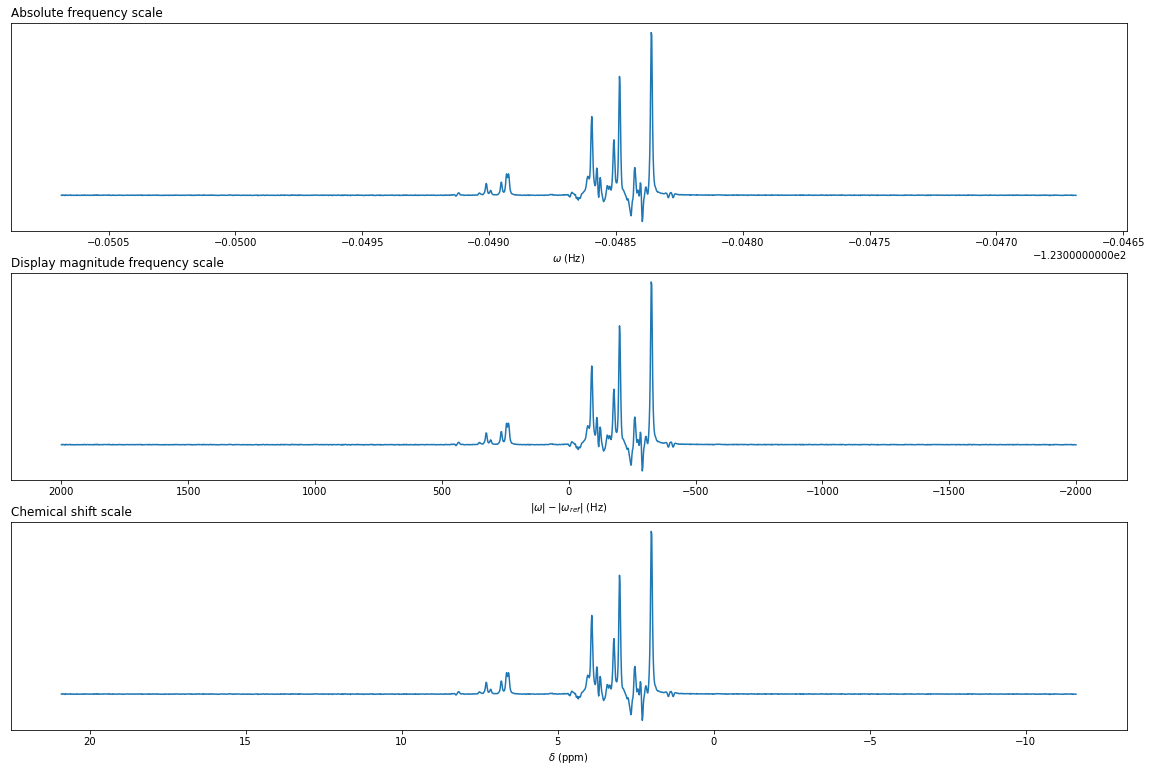

In [7]:
# Make absolute frequency scale (remember the -ve sign in omega=-gamma.B0)
def plot_frequency_orientation(data,header):
    cf_mhz = checkCFUnits(header['centralFrequency'],units='MHz')

    npoints = data.shape[0]
    frequency_axis = np.linspace(-header['bandwidth']/2,header['bandwidth']/2,npoints) 
    abs_freq_axis = -cf_mhz + frequency_axis/1E6
    # Display frequency axis
    frequency_axis *= -1
    # Chemical shift axis (shifted to TMS)
    c_shift_axis = 4.65+ frequency_axis/cf_mhz

    spec_fft = np.fft.fftshift(np.fft.fft(data))

    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,13))
    ax1.plot(abs_freq_axis,np.real(spec_fft))
    ax1.set_yticks([])
    ax1.set_xlabel('$\omega$ (Hz)')
    ax1.set_title('Absolute frequency scale',loc='left')

    ax2.plot(frequency_axis,np.real(spec_fft))
    ax2.set_yticks([])
    ax2.invert_xaxis()
    ax2.set_xlabel('$|\omega|-|\omega_{ref}|$ (Hz)')
    ax2.set_title('Display magnitude frequency scale',loc='left')

    ax3.plot(c_shift_axis,np.real(spec_fft))
    ax3.set_yticks([])
    ax3.invert_xaxis()
    ax3.set_xlabel('$\delta$ (ppm)')
    ax3.set_title('Chemical shift scale',loc='left')

    plt.show()

plot_frequency_orientation(full_data[0,0,0,:,0,0,1],header)

In [13]:
# Cleanup
shutil.rmtree(dyexample / 'ON')
shutil.rmtree(dyexample / 'OFF')

### Form dimension information

In [8]:
dimensions_dict = {'dim_5': 'DIM_COIL',
                   'dim_6': 'DIM_DYN',
                   'dim_7': 'DIM_EDIT',
                   'dim_7_info': 'j-difference editing, two conditions',
                   'dim_7_header': {'EditCondition': ['ON', 'OFF']}
                  }

### Required metadata

In [9]:
dwelltime = 1/header['bandwidth'] # For pixdim[4]

metadata = {'SpectrometerFrequency': [header['centralFrequency']/1E6, ],
            'ResonantNucleus': ['1H',],           
            'EditPulse': {'ON':{'PulseOffset':1.9},
                          'OFF': {'PulseOffset':7.8}}
           }

full_metadata = metadata
full_metadata.update(dimensions_dict)
metadata_json = json.dumps(full_metadata)

### Orientation information
No spatial position but pixel dimensions of [20 20 30]

In [10]:
newobj = nib.nifti2.Nifti2Image(full_data,None)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[1:4] = [20, 20, 30]
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form = 0
newobj.header.set_qform(None,code=0)

# Set version information
newobj.header['intent_name'] = b'mrs_v0_3'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, metadata_json.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,dyexample / 'example_06.nii.gz')

## Example 2 & 3 - Variable TE
Modify a simple PRESS sequence to modulate with a variable TE  
  
Original has 35 ms TE with 19.25 ms as the second TE  

Simulate NAA only for speed.

In [11]:
with open('dynamic_examples_aux/svs_se_35.json') as jsonf:
    original_json = json.load(jsonf)

original_json


{'sequenceName': 'svs_se',
 'description': '35 ms 3T PRESS Siemens sequence, no spatial treatment',
 'B0': 3.0,
 'centralShift': 4.65,
 'Rx_Points': 8192,
 'Rx_SW': 4000,
 'Rx_LW': 2,
 'Rx_Phase': 0.695,
 'x': [-25, 25],
 'y': [-25, 25],
 'z': [-25, 25],
 'resolution': [1, 1, 1],
 'CoherenceFilter': [-1, 1, -1],
 'RFUnits': 'Hz',
 'GradUnits': 'mT',
 'spaceUnits': 'mm',
 'RF': [{'time': 0.0001,
   'frequencyOffset': -283.0,
   'phaseOffset': 0,
   'amp': [2500.0],
   'phase': [0.0],
   'grad': [0, 0, 0]},
  {'time': 0.0001,
   'frequencyOffset': -283.0,
   'phaseOffset': 0,
   'amp': [5000.0],
   'phase': [0.0],
   'grad': [0, 0, 0]},
  {'time': 0.0001,
   'frequencyOffset': -283.0,
   'phaseOffset': 0,
   'amp': [5000.0],
   'phase': [0.0],
   'grad': [0, 0, 0]}],
 'delays': [0.007775, 0.0174, 0.009575],
 'rephaseAreas': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]}

In [14]:
add_TE = np.arange(0.0,100.0,10.0)
add_TE /= 1000.0
print(add_TE)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [26]:
out_basis = []
for te in add_TE:
    current_json = deepcopy(original_json)
    current_json['delays'][1] += te/2
    current_json['delays'][2] += te/2
    new_te = np.round(1000*(np.sum(current_json['delays'])+0.00015+0.0001))
    
    # Write the new json to file
    current_json_file = dyexample / f'svs_se_{new_te:03.0f}.json'
    with open(current_json_file,'w') as jsonf:
        json.dump(current_json,jsonf)
    
    cbasis =  f'basis_{new_te:03.0f}'
    out_basis.append(dyexample / cbasis)
    check_call(['fsl_mrs_sim',
                '-m', 'NAA',
                '-o', str(dyexample / cbasis),
                '-p', '2.0',
                '--overwrite',
                str(current_json_file)])
    
    (dyexample / f'svs_se_{new_te:03.0f}.json').unlink()
    

In [27]:
full_data = np.zeros((2048,4,len(out_basis)),dtype=complex)

for idx, basis in enumerate(out_basis):
    # Generate multi-coil dataset
    fids, header, _ = synthetic_from_basis.syntheticFromBasisFile(str(basis),
                                                broadening=(9.0, 9.0),
                                                coilamps=[1.0, 0.85 , 0.65 , 1.15],
                                                coilphase=[0.0, 1.5, 1.0, 3.5],
                                                noisecovariance= 0.5 * np.eye(4))

    full_data[:,:,idx] = fids.conj()

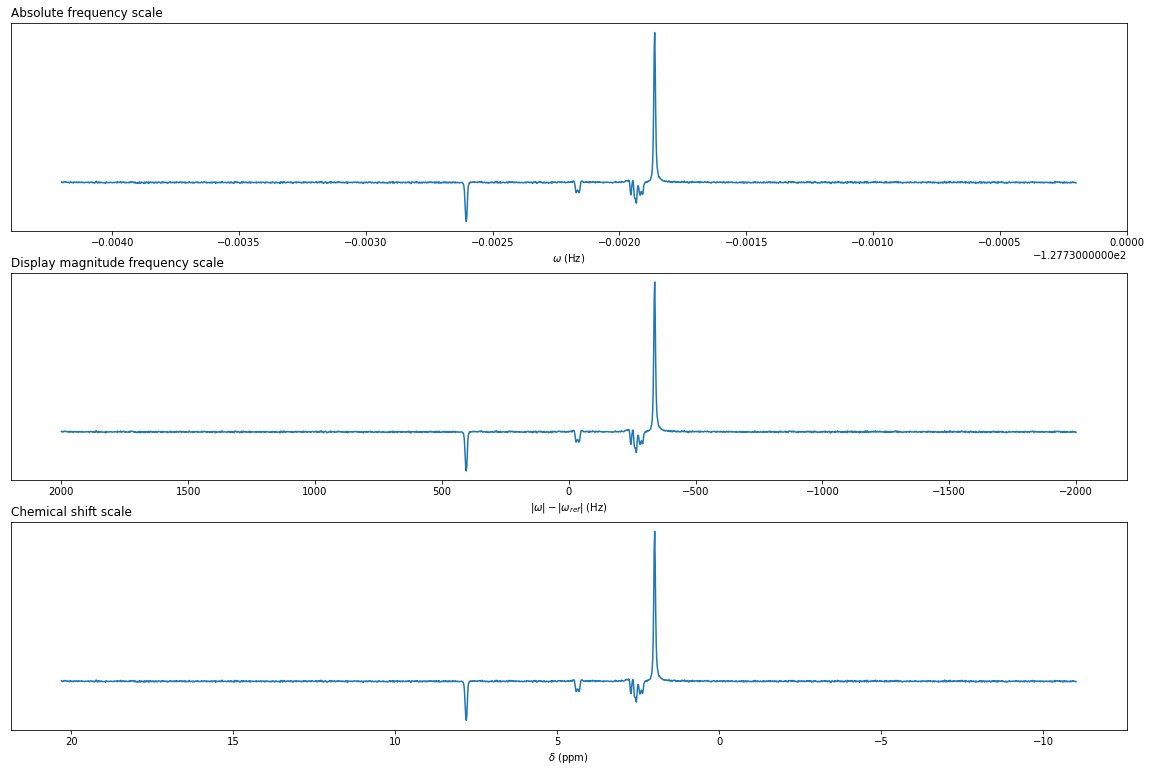

In [28]:
plot_frequency_orientation(full_data[:,0,9],header)

In [34]:
for basis in out_basis:
    shutil.rmtree(basis)

## Write data out

### Form complex data
Dimensions 1-3 are space  
Dimension 4 is time  
Dimension 5 is coils  
Dimension 6 is the indirect j-evolution 

In [29]:
newshape = (1,1,1)+full_data.shape
full_data = full_data.reshape(newshape)
print(full_data.shape)

(1, 1, 1, 2048, 4, 10)


### Form dimension information

In [30]:
dimensions_dict = {'dim_5': 'DIM_COIL',
                   'dim_6': 'DIM_INDIRECT_0',
                   'dim_6_info': 'Incremented echo time for j-evolution',
                   'dim_6_header': {'EchoTime': (0.035 + add_TE).tolist()}
                  }

dimensions_dict_short = {'dim_5': 'DIM_COIL',
                         'dim_6': 'DIM_INDIRECT_0',
                         'dim_6_info': 'Incremented echo time for j-evolution',
                         'dim_6_header': {'EchoTime': {'start': 0.035, 'increment': 0.01}}
                         }

### Required metadata

In [31]:
dwelltime = 1/header['bandwidth'] # For pixdim[4]

metadata = {'SpectrometerFrequency': [header['centralFrequency']/1E6,],
            'ResonantNucleus': ['1H',]}


In [32]:
full_metadata = metadata
full_metadata.update(dimensions_dict)
metadata_json = json.dumps(full_metadata)

full_metadata_sh = metadata
full_metadata_sh.update(dimensions_dict_short)
metadata_json_sh = json.dumps(full_metadata_sh)

### Orientation information
No spatial position but pixel dimensions of [20 20 20]

In [33]:
newobj = nib.nifti2.Nifti2Image(full_data,None)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[1:4] = [20, 20, 20]
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form = 0
newobj.header.set_qform(None,code=0)

# Set conformance level 
newobj.header['intent_name'] = b'mrs_v0_3'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, metadata_json_sh.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,dyexample / 'example_07.nii.gz')

newobj.header.extensions.clear()

# Write extension
extension = nib.nifti1.Nifti1Extension(44, metadata_json.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,dyexample / 'example_08.nii.gz')

## Example 4 - Fingerprinting

Vary a simple signal with TE and TR and pulse flip-angle.  

Fudge the exact signal equations.

In [35]:
fp_TE = np.linspace(0.01,0.2,20)
fp_TR = np.linspace(0.1,2,20)
flip = np.linspace(10,100,20) * np.pi/180

T1 = 1
T2 = 0.100

ps = np.sin(flip) * np.exp(-fp_TE/T2) * (1-np.exp(-fp_TR/T1))/(1-np.cos(flip)*np.exp(-fp_TR/T1))

In [36]:
full_data = np.zeros((2048,len(ps)),dtype=complex)
phase_con = []
for idx,sig_scale in enumerate(ps):
    phase = np.pi * (idx % 2)
    phase_con.append(phase)
    fid,header = synthetic.syntheticFID(chemicalshift=[0], amplitude=[sig_scale], phase=[phase], damping=[20], noisecovariance=[[0.01]])
    full_data[:,idx] = fid[0]
    
newshape = (1,1,1)+full_data.shape
full_data = full_data.reshape(newshape)
print(full_data.shape)

(1, 1, 1, 2048, 20)


In [37]:
dimensions_dict = {'dim_5': 'DIM_USER_0',
                   'dim_5_use': 'Acquisition index with variable TE, TR and pulse flip-angle',
                   'dim_5_header': {'EchoTime': fp_TE.tolist(),
                                    'RepetitionTime': fp_TR.tolist(),
                                    'ExcitationFlipAngle': flip.tolist(),
                                    'inv_condition':{'Value': phase_con,
                                                     'Description' : 'User defined inversion condition.'}
                                   }
                  }

In [38]:
dwelltime = 1/header['bandwidth'] # For pixdim[4]

metadata = {'SpectrometerFrequency': [header['centralFrequency'],],
            'ResonantNucleus': ['1H',]}

full_metadata = metadata

full_metadata.update(dimensions_dict)
metadata_json = json.dumps(full_metadata)

In [39]:
newobj = nib.nifti2.Nifti2Image(full_data,None)

# Write new header
pixDim = newobj.header['pixdim']
pixDim[1:4] = [20, 20, 20]
pixDim[4] = dwelltime
newobj.header['pixdim'] = pixDim

# Set q_form = 0
newobj.header.set_qform(None,code=0)

# Set version information 
newobj.header['intent_name'] = b'mrs_v0_3'

# Write extension
extension = nib.nifti1.Nifti1Extension(44, metadata_json.encode('UTF-8'))
newobj.header.extensions.append(extension)

# # From nii obj and write    
nib.save(newobj,dyexample / 'example_09.nii.gz')